In [1]:
# Load necessary libraries
library(DBI)
library(odbc)
library(dplyr)

# DB Connection
connection_string <- "Driver={ODBC Driver 17 for SQL Server};Server=analityk.wwsi.edu.pl,50221;Uid=student;Pwd=ciekawski;Database=Smogoliczka;"
conn <- dbConnect(odbc::odbc(), .connection_string = connection_string)

# Fetch Map Points
map_points_query <- "SELECT Kontur.ToString() AS Data, Nazwa FROM KonturyWoj ORDER BY KodTeryt;"
map_points <- dbGetQuery(conn, map_points_query)

# Fetch Air Polution Data
air_polution_query <- "
    WITH polution_data AS  (
        SELECT
            YEAR(p.Data) AS Year
            ,DATEPART(quarter, p.Data) AS Quarter
            ,AVG(p.dane) AS Value
            ,rp.NazwaParametru AS Parameter
            ,rp.IdParametru AS ParameterId
            ,LOWER(sp.Wojewodztwo) AS Region
        FROM
            Smogoliczka.dbo.Pomiary AS p
        INNER JOIN Smogoliczka.dbo.RodzajeParametrow AS rp
           ON p.IDRodzaju = rp.IdParametru
        INNER JOIN Smogoliczka.dbo.StacjePomiarowe AS sp
           ON p.IDStacji = sp.IdStacji
        GROUP BY
            YEAR(p.Data)
            ,DATEPART(quarter, p.Data)
            ,rp.ParKod
            ,rp.NazwaParametru
            ,rp.IdParametru
            ,LOWER(sp.Wojewodztwo)
    )
    SELECT
        pd.*
        , n.Poziom
    FROM polution_data AS pd
    INNER JOIN Smogoliczka.dbo.Normy AS n
        ON pd.ParameterId = n.IdParametru
        AND pd.Value BETWEEN n.od AND n.do
    ORDER BY pd.Value DESC;
"
air_polution <- dbGetQuery(conn, air_polution_query)

# Close connection
dbDisconnect(conn)


Dołączanie pakietu: ‘dplyr’


Następujące obiekty zostały zakryte z ‘package:stats’:

    filter, lag


Następujące obiekty zostały zakryte z ‘package:base’:

    intersect, setdiff, setequal, union




`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.”
Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”


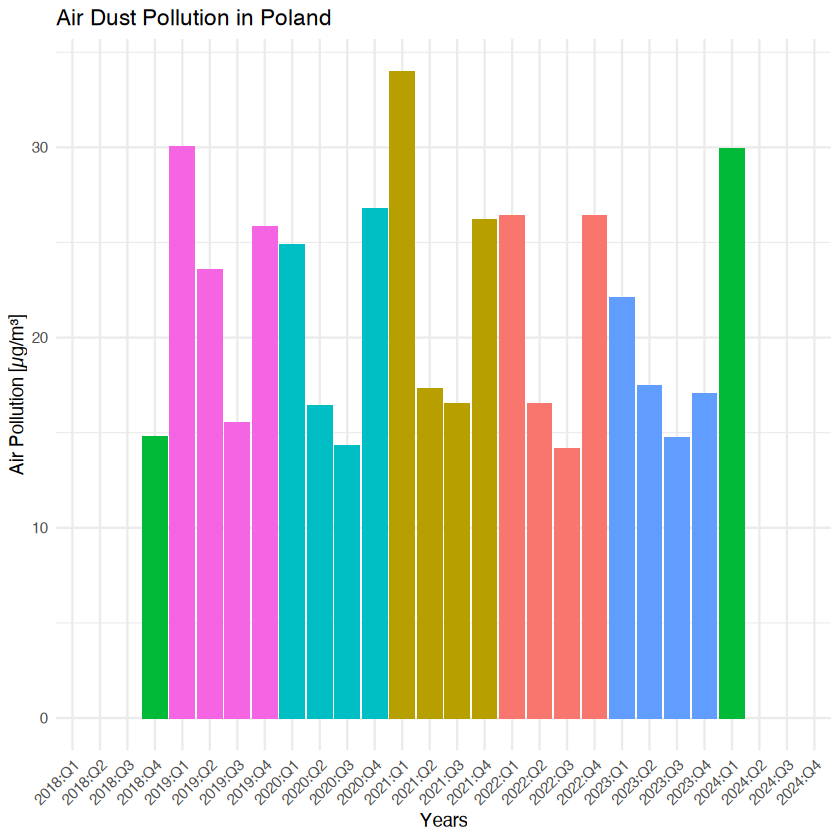

In [3]:
# Load necessary libraries
library(dplyr)
library(ggplot2)
library(tidyr)

# Assuming air_polution is already loaded

# Filter for specific pollutants
pm_polution <- air_polution %>%
  filter(Parameter %in% c("pył zawieszony PM10", "pył zawieszony PM2.5"))

# Group by & parse columns
pm_polution <- pm_polution %>%
  group_by(Year, Quarter) %>%
  summarize(Value = mean(Value, na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(Quarter = paste0("Q", Quarter))

# Pivot to wide format
pm_polution_wide <- pm_polution %>%
  pivot_wider(names_from = Quarter, values_from = Value)

# Add Colors
colors <- c("yellow", "orange", "darkorange", "crimson", "red", "blue")
pm_polution_wide$Color <- case_when(
  pm_polution_wide$Year == 2019 ~ colors[1],
  pm_polution_wide$Year == 2020 ~ colors[2],
  pm_polution_wide$Year == 2021 ~ colors[3],
  pm_polution_wide$Year == 2022 ~ colors[4],
  pm_polution_wide$Year == 2023 ~ colors[5],
  pm_polution_wide$Year == 2024 ~ colors[6],
  TRUE ~ 'gray'
)

# Final Transformation
pm_polution_long <- pm_polution_wide %>%
  pivot_longer(cols = starts_with("Q"), names_to = "Quarter", values_to = "Value") %>%
  mutate(YearQuarter = paste(Year, Quarter, sep = ":")) %>%
  arrange(Year, Quarter)

# Plot
ggplot(pm_polution_long, aes(x = YearQuarter, y = Value, fill = Color)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(x = "Years", y = "Air Pollution [µg/m³]", title = "Air Dust Pollution in Poland") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  guides(fill = FALSE)


`summarise()` has grouped output by 'Parameter'. You can override using the `.groups` argument.


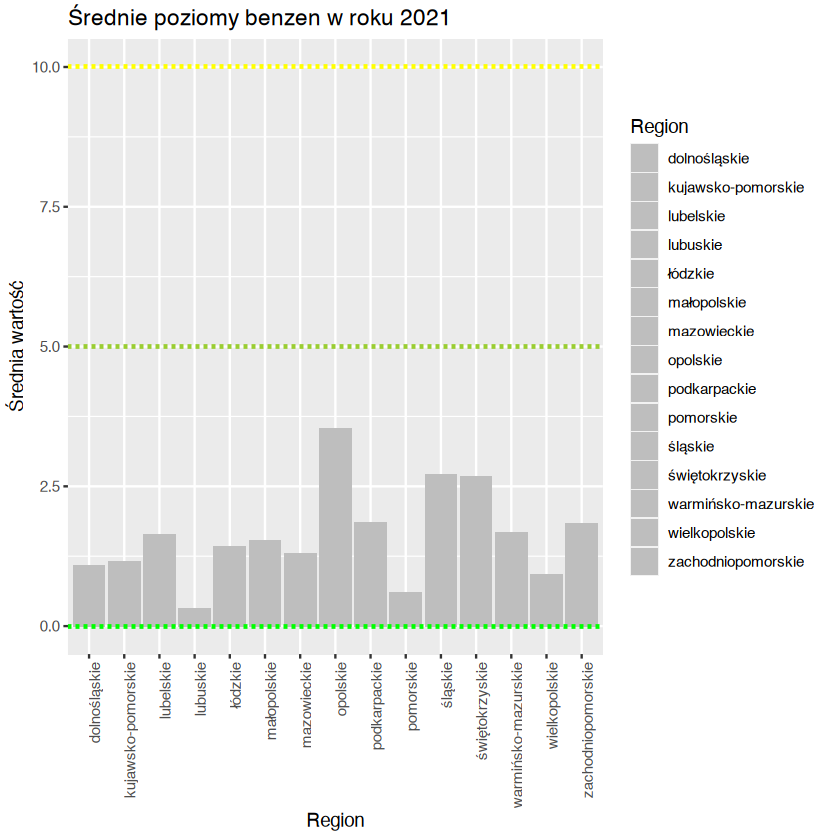

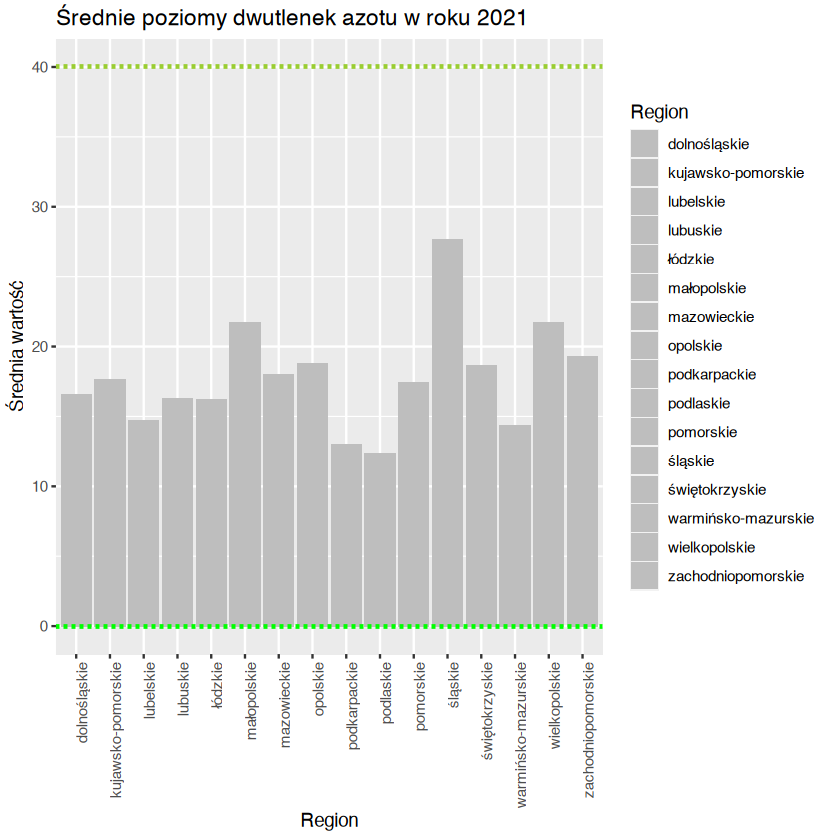

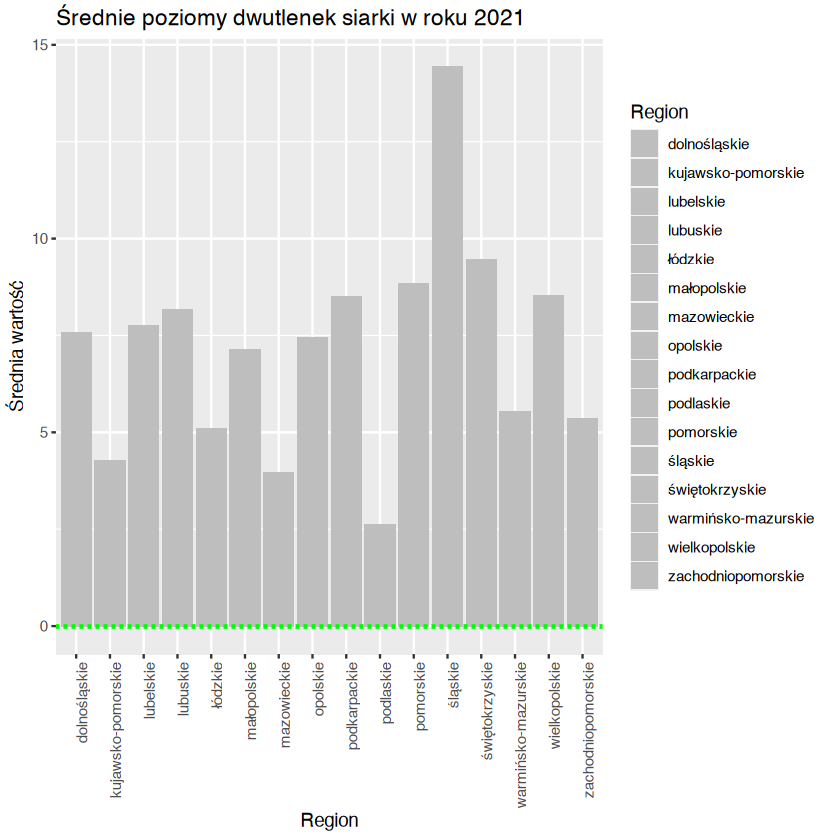

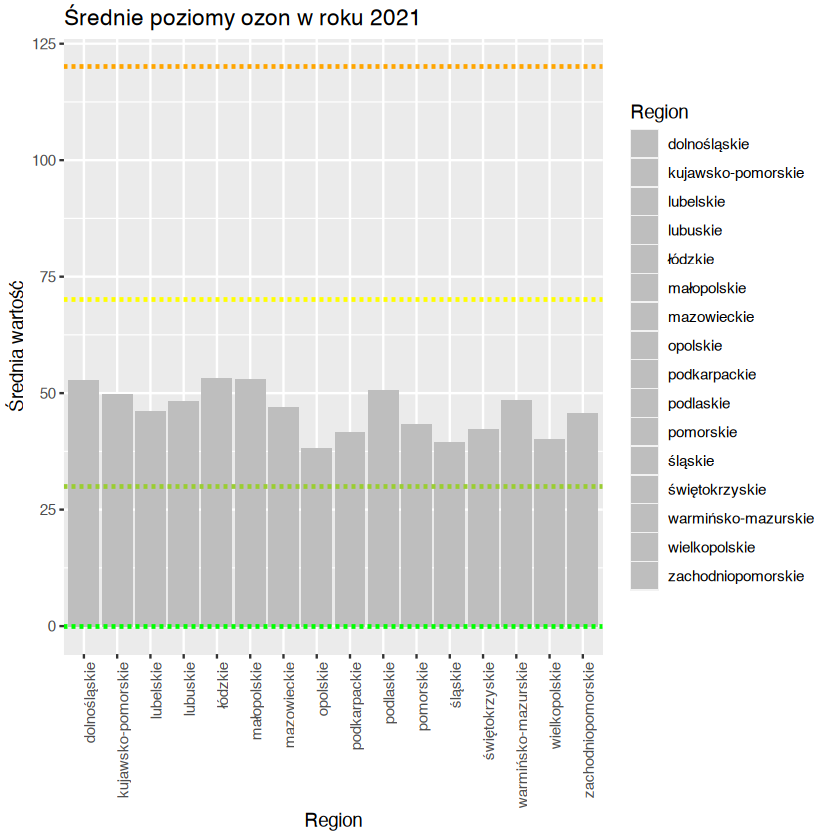

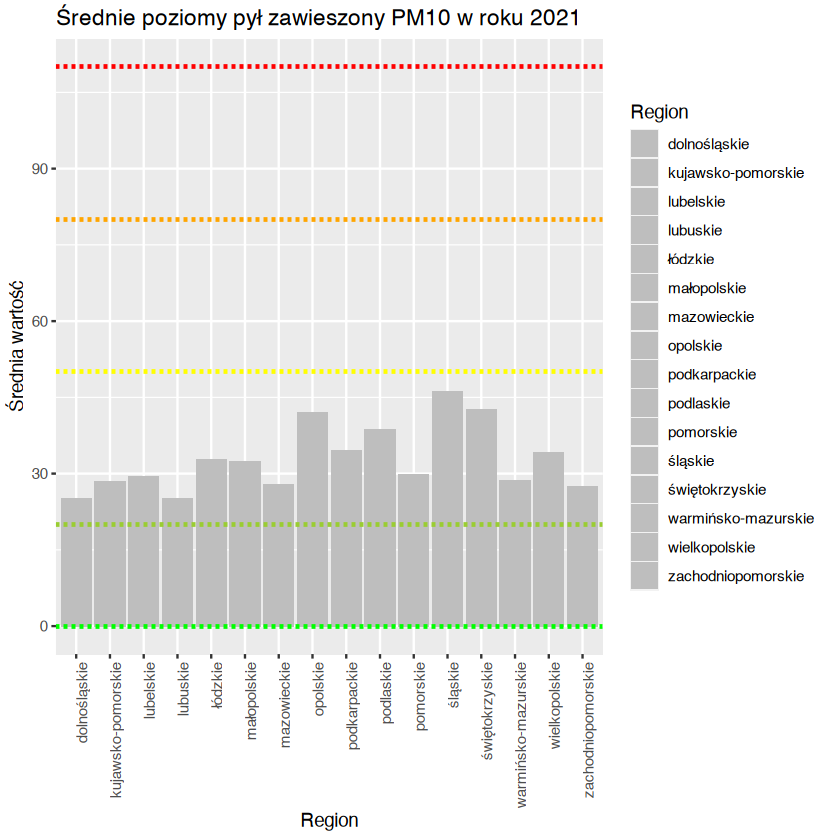

`summarise()` has grouped output by 'Parameter'. You can override using the `.groups` argument.


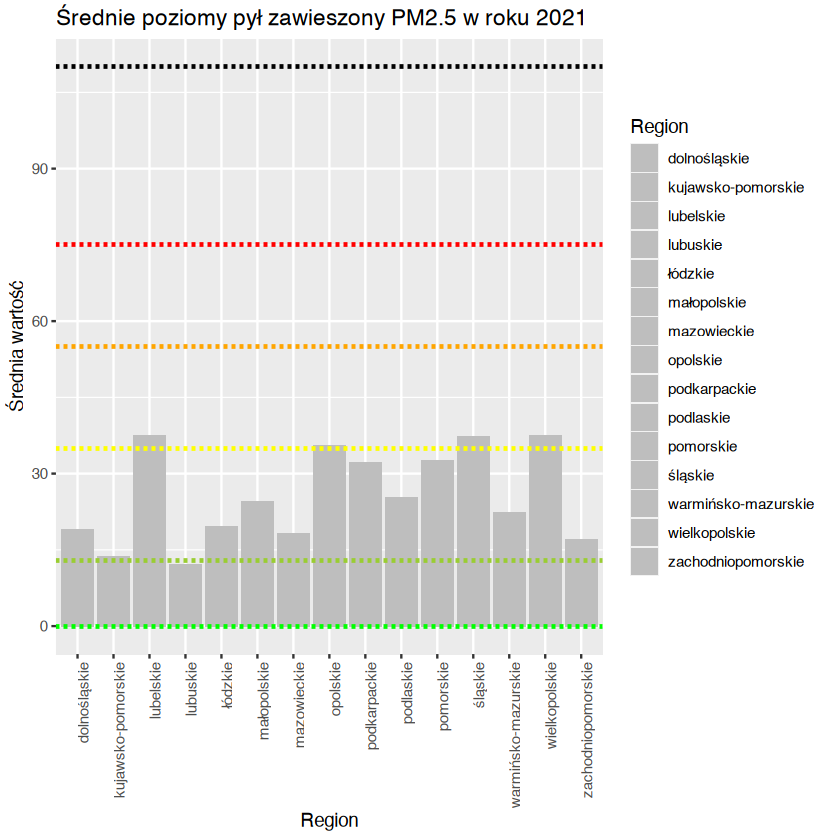

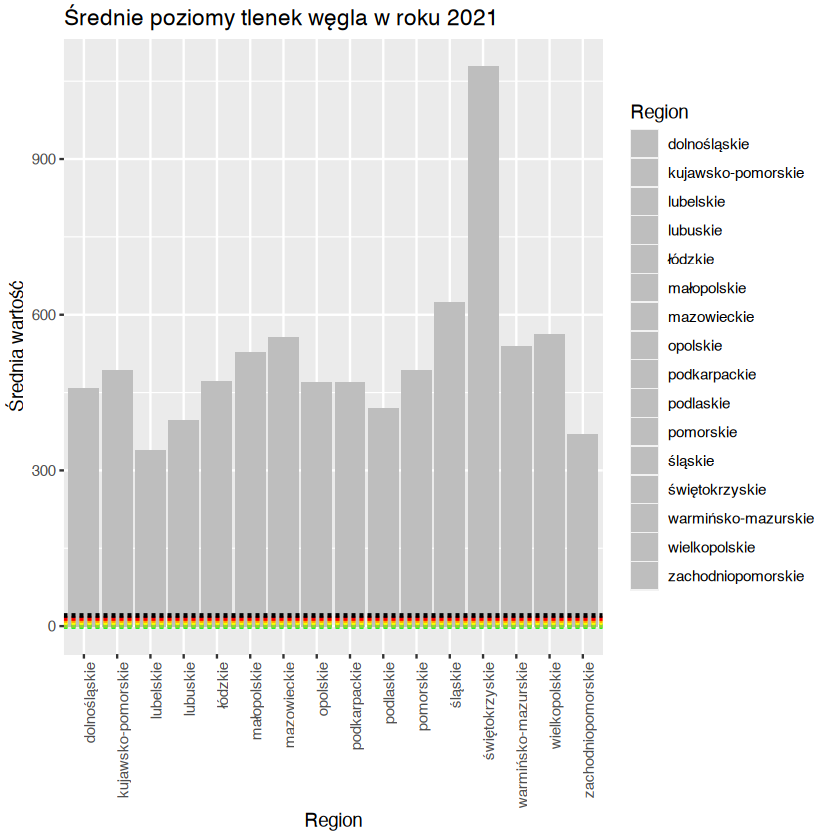

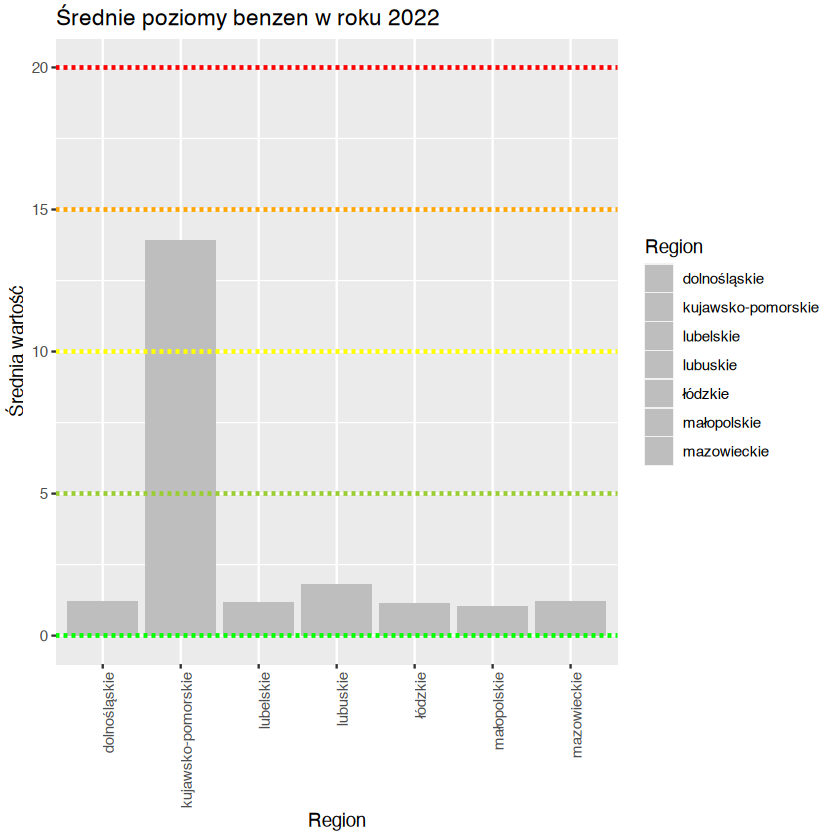

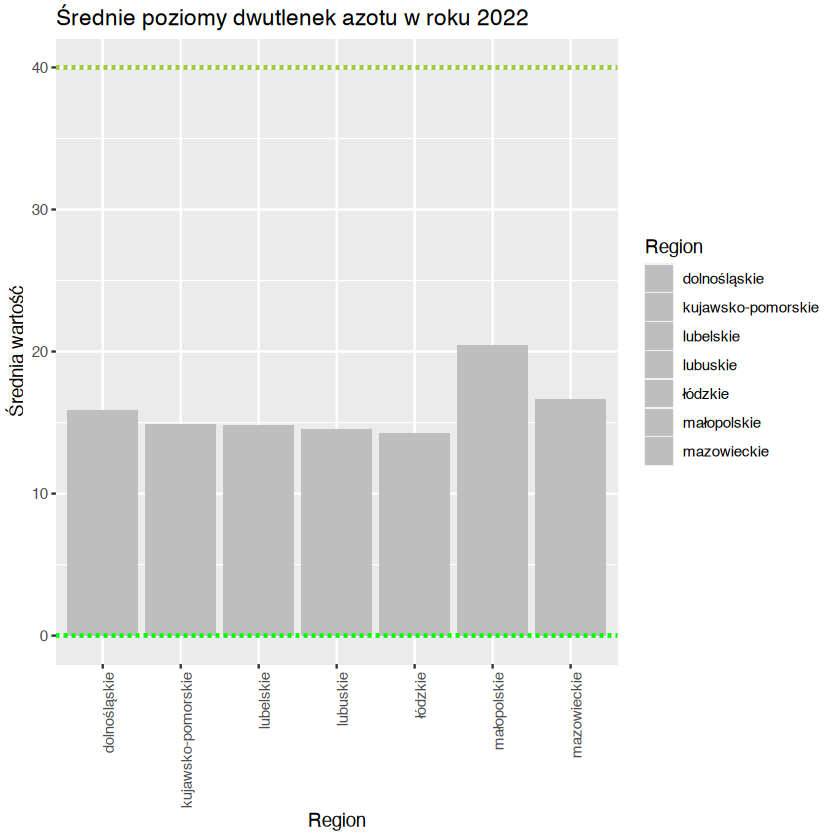

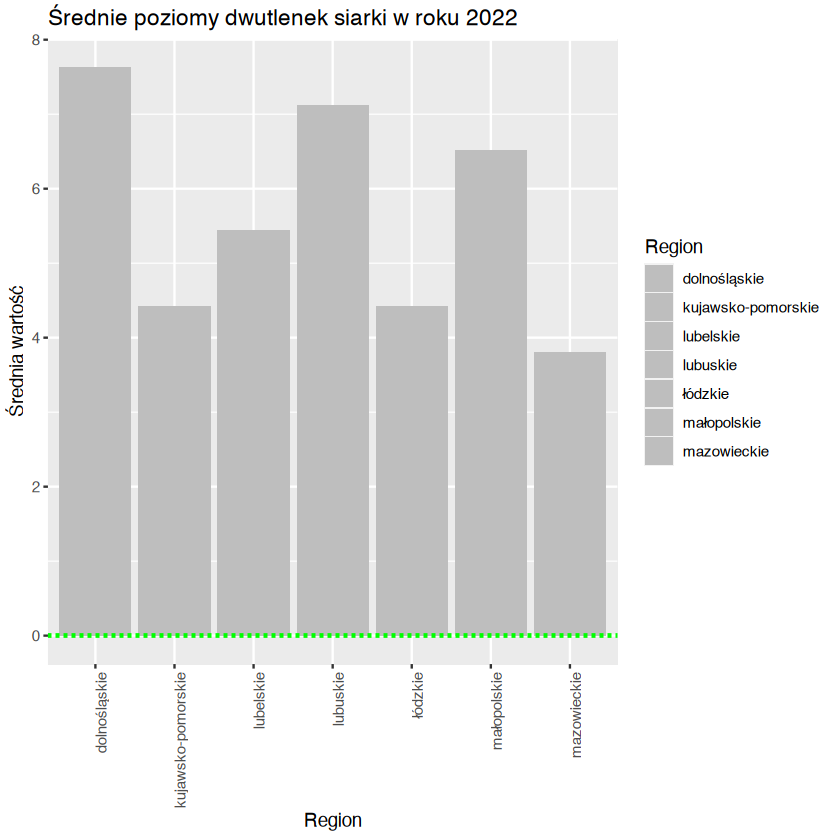

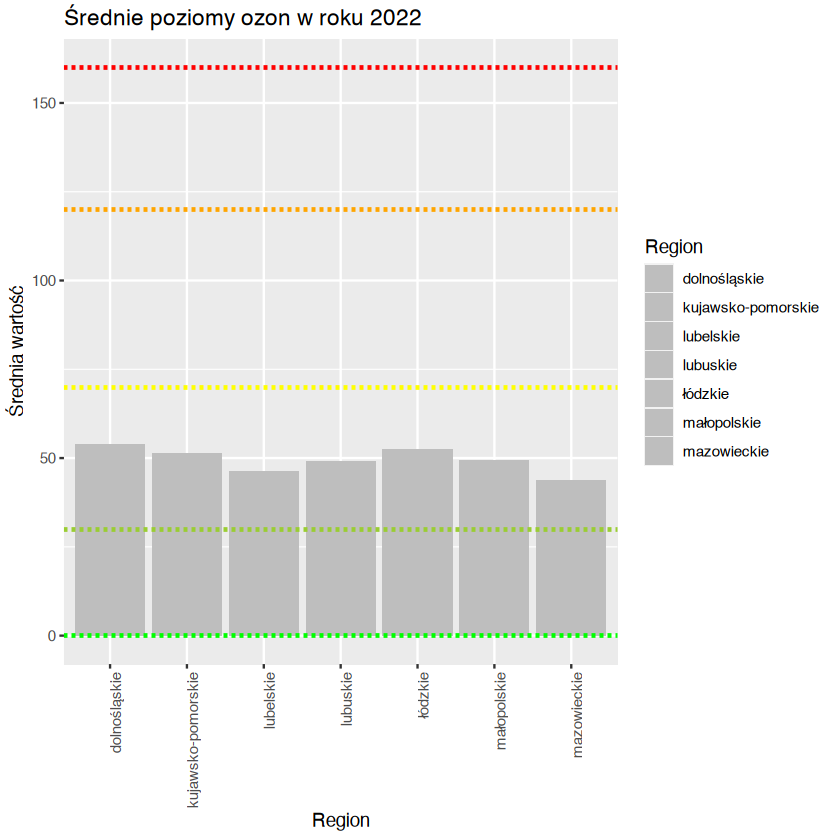

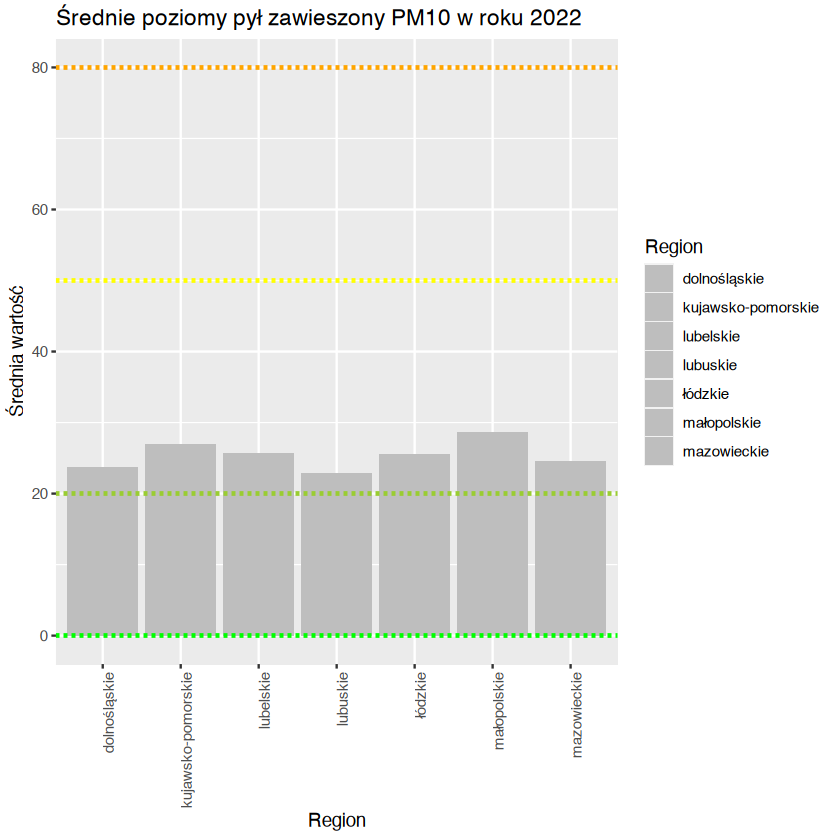

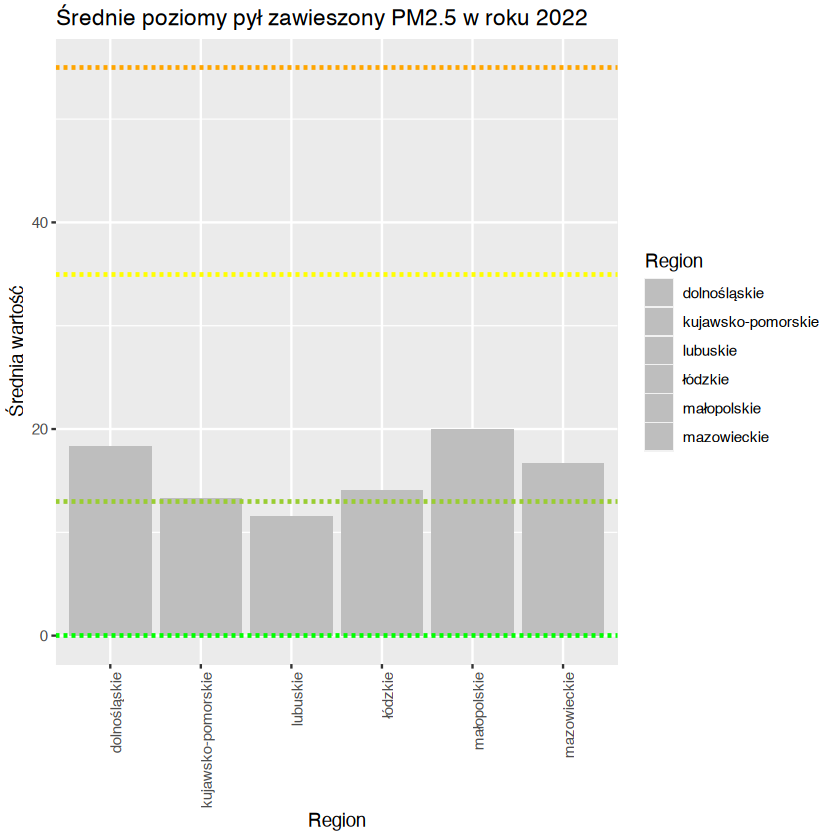

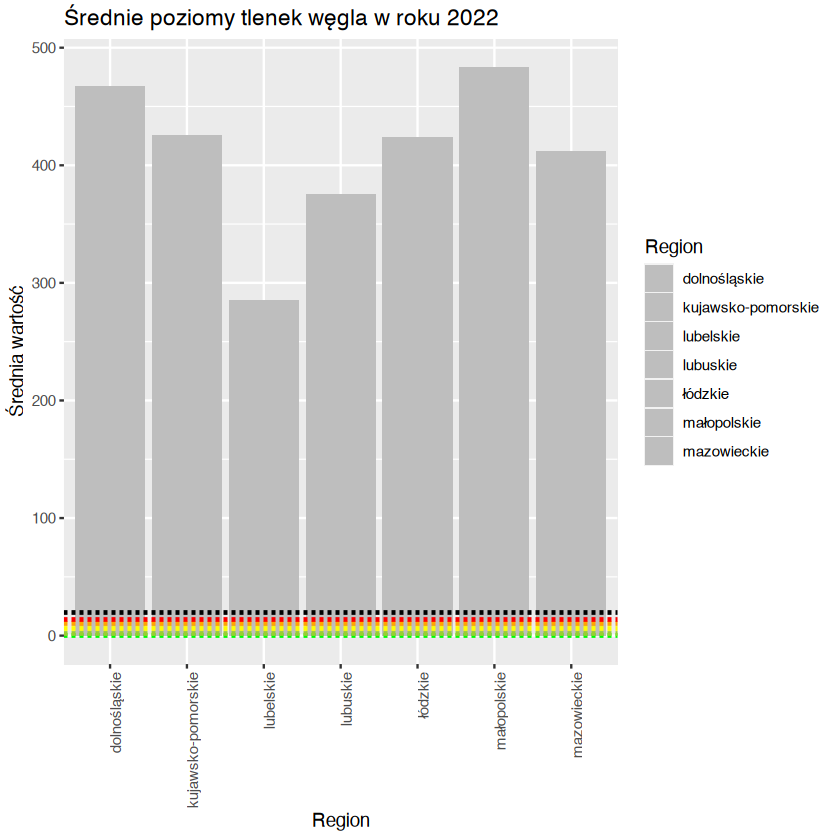

In [8]:
# Load necessary libraries
library(DBI)
library(odbc)
library(dplyr)
library(ggplot2)
library(scales)

# DB Connection (assuming you have already set up the connection as shown earlier)
# Fetch Norms Data
conn <- dbConnect(odbc::odbc(), .connection_string = connection_string)
normy_query <- "SELECT Wskaznik, Poziom, od, do FROM Normy;"
normy_data <- dbGetQuery(conn, normy_query)
dbDisconnect(conn)

# Mapowanie nazw
mapowanie_nazw <- list(
  SO2 = 'dwutlenek siarki',
  CO = 'tlenek węgla',
  O3 = 'ozon',
  PM10 = 'pył zawieszony PM10',
  PM25 = 'pył zawieszony PM2.5',
  NO2 = 'dwutlenek azotu',
  C6H6 = 'benzen'
)

# Kolory poziomów
kolory_poziomow <- list(
  'Bardzo dobry' = 'green',
  'Dobry' = 'yellowgreen',
  'Umiarkowany' = 'yellow',
  'Dostateczny' = 'orange',
  'Zły' = 'red',
  'Bardzo zły' = 'black'
)

# Prepare norms data
normy_dict <- list()
for (row in 1:nrow(normy_data)) {
  wskaźnik <- normy_data[row, 'Wskaznik']
  wskaźnik_full_name <- ifelse(is.null(mapowanie_nazw[[wskaźnik]]), wskaźnik, mapowanie_nazw[[wskaźnik]])
  
  if (is.null(normy_dict[[wskaźnik_full_name]])) {
    normy_dict[[wskaźnik_full_name]] <- list()
  }
  normy_dict[[wskaźnik_full_name]][[normy_data[row, 'Poziom']]] <- normy_data[row, 'od']
}

# Visualize Data Function
visualize_data <- function(data, year, norms, kolory_poziomow, max_scale_factor = 3) {
  grouped_data <- data %>%
    group_by(Parameter, Region) %>%
    summarize(Value = mean(Value, na.rm = TRUE)) %>%
    ungroup()

  for (parameter in unique(grouped_data$Parameter)) {
    parameter_data <- filter(grouped_data, Parameter == parameter)
    max_value <- max(parameter_data$Value, na.rm = TRUE)

    p <- ggplot(parameter_data, aes(x = Region, y = Value, fill = Region)) +
      geom_bar(stat = "identity") +
      scale_fill_manual(values = rep('grey', nrow(parameter_data))) +
      labs(title = paste('Średnie poziomy', parameter, 'w roku', year),
           x = 'Region', y = 'Średnia wartość') +
      theme(axis.text.x = element_text(angle = 90, hjust = 1))

    if (parameter %in% names(norms)) {
      for (level in names(norms[[parameter]])) {
        norm_value <- norms[[parameter]][[level]]
        if (norm_value <= max_value * max_scale_factor) {
          p <- p + geom_hline(yintercept = norm_value, linetype = "dashed",
                              color = kolory_poziomow[[level]], size = 1)
        }
      }
    }

    print(p)    
  }
}

# Example call of the function
# Assuming air_polution is already loaded
for (year in 2021:2022) {
  yearly_data <- filter(air_polution, Year == year)
  visualize_data(yearly_data, year, normy_dict, kolory_poziomow)
}